# Import

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import os
import pathlib
import matplotlib as plt

# 1. Load Data

In [37]:
# Create a list to add csv files as df
Bldg = []

# Read all building data and append to list
for path in pathlib.Path("/Users/alialyakoob/Desktop/ASU/RA/Data/Model_Data/microclimate_model/Combined/dataset1").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg.append(current_file)
    

## 1.1 Preprocessing 

1. Adding Month, Hour, and Minute to data
2. Removing hours out of ENVI-met accuracy range (after 9 pm)
3. Add CHWTON/SQFT to columns using condition area for each building taken from
    https://fdm-apps.asu.edu/UFRM/FDS/FacilityData.aspx

In [38]:
# Create Month, Hour, and Minute column for all dataframes in list
for i in range(len(Bldg)):
    Bldg[i].Date_Time = pd.to_datetime(Bldg[i].Date_Time)
    Bldg[i]['Month_num'] = Bldg[i].Date_Time.dt.month
    Bldg[i]['Hour_num'] = Bldg[i].Date_Time.dt.hour
    Bldg[i]['Minute_num'] = Bldg[i].Date_Time.dt.minute

# Remove data after 9pm
for i in range(len(Bldg)):
    Bldg[i] = Bldg[i][(Bldg[i]['Hour_num'] <= 20) & (Bldg[i]['Hour_num'] > 0)]

# Add Column: CHWTON/Condition Area (SqFt) or ['CHWTON/SQFT']
cond_area = {'Noble Library':88658,'Biodesign B':132215,'Biodesign C':145410,
             'Biodesign A':133016,'Psychology':69864,'Goldwater':165237,'Schwada COB':99857,
             'ISTB 2':41404,'Bulldog Hall':68067,'ISTB 4':231646,'Psychology North':43034}
for i in range(len(Bldg)):
    if Bldg[i]['bldgname'][0] in cond_area:
        Bldg[i]['CHWTON/SQFT'] = Bldg[i]['CHWTON'] / cond_area[Bldg[i]['bldgname'][0]]

<ipython-input-38-5ea8a359b387>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bldg[i]['CHWTON/SQFT'] = Bldg[i]['CHWTON'] / cond_area[Bldg[i]['bldgname'][0]]


# 2. Single Building

## 2.1 Select Building

In [26]:
# Ask user to select building
for i in range(len(Bldg)):
    print(i, Bldg[i]['bldgname'][0])

bldgnum = int(input("Enter the number of the building from the list above: "))

Bldg[bldgnum]

0 Noble Library
1 Biodesign B
2 Biodesign C
3 Biodesign A
4 Psychology
5 Goldwater
6 Schwada COB
7 ISTB 2
8 Bulldog Hall
9 ISTB 4
10 Psychology North
Enter the number of the building from the list above: 5


,bldgname,Date,Time,Air Temp,Rel Hum,KW,CHWTON,HTmmBTU,Date_Time,Month_num,Hour_num,Minute_num,CHWTON/SQFT
0,Goldwater,2018-05-16,05:00,24.578893,19.840353,500.10,204.82,0.09,2018-05-16 05:00:00,5,5,0,0.001240
1,Goldwater,2018-05-16,05:15,23.858227,23.289624,496.34,203.23,0.09,2018-05-16 05:15:00,5,5,15,0.001230
2,Goldwater,2018-05-16,05:30,23.687255,23.023568,494.19,197.45,0.09,2018-05-16 05:30:00,5,5,30,0.001195
3,Goldwater,2018-05-16,05:45,23.600943,23.097939,497.37,201.17,0.09,2018-05-16 05:45:00,5,5,45,0.001217
4,Goldwater,2018-05-16,06:00,23.497420,23.217319,494.77,204.34,0.09,2018-05-16 06:00:00,5,6,0,0.001237
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,Goldwater,2018-09-29,19:45,34.705012,19.622483,511.98,333.90,0.13,2018-09-29 19:45:00,9,19,45,0.002021
599,Goldwater,2018-09-29,20:00,34.483275,20.199395,512.26,336.72,0.14,2018-09-29 20:00:00,9,20,0,0.002038
600,Goldwater,2018-09-29,20:15,34.271398,20.748160,510.91,330.15,0.15,2018-09-29 20:15:00,9,20,15,0.001998
601,Goldwater,2018-09-29,20:30,34.119319,21.027916,513.00,332.60,0.16,2018-09-29 20:30:00,9,20,30,0.002013


## 2.2 EDA

### 2.2.1 Boxplots

0 bldgname
1 Date
2 Time
3 Air Temp
4 Rel Hum
5 KW
6 CHWTON
7 HTmmBTU
8 Date_Time
9 Month_num
10 Hour_num
11 Minute_num
12 CHWTON/SQFT
Enter the number of the following data columns to graph boxplot: 12

 Goldwater


<AxesSubplot:title={'center':'CHWTON/SQFT'}, xlabel='Hour_num'>

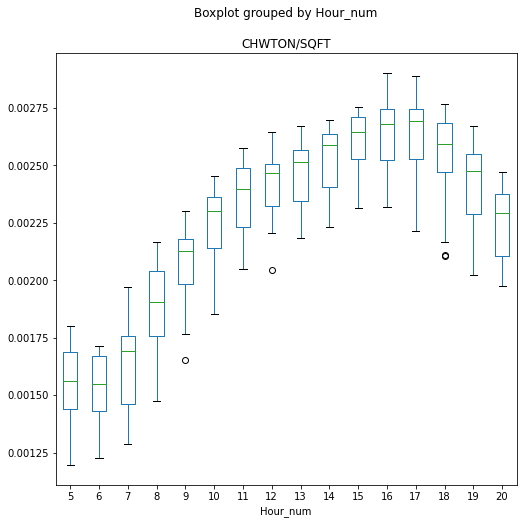

In [27]:
# Show df columns to select for boxplot
x = Bldg[bldgnum].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg[bldgnum]['bldgname'][0])
Bldg[bldgnum].boxplot(by='Hour_num', column=x[colname], grid = False, figsize = (8,8))

### 2.2.2 Time Series

Enter month number: 6

 5 day(s) found in Jun 

0 bldgname
1 Date
2 Time
3 Air Temp
4 Rel Hum
5 KW
6 CHWTON
7 HTmmBTU
8 Date_Time
9 Month_num
10 Hour_num
11 Minute_num
12 CHWTON/SQFT
Enter y-axis from column list above: 3


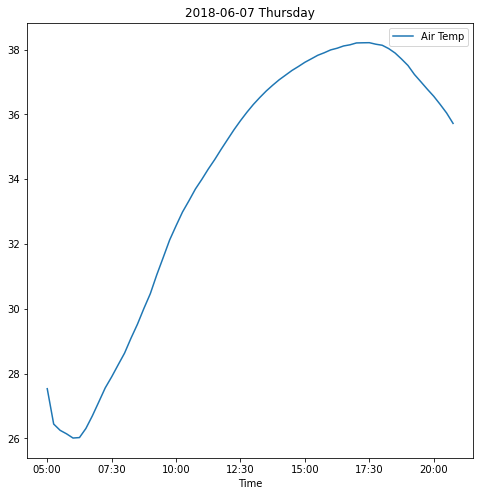

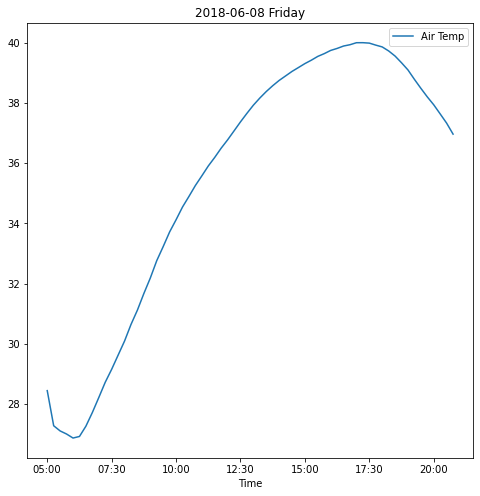

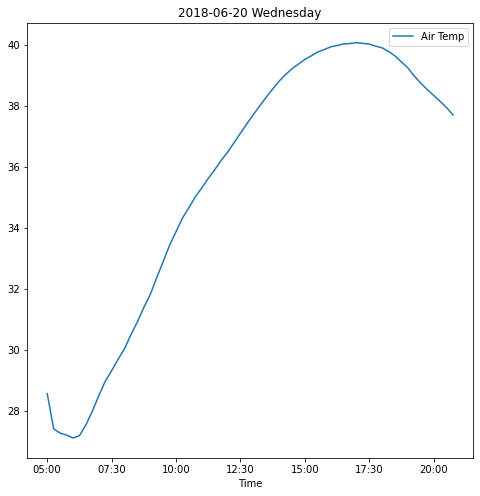

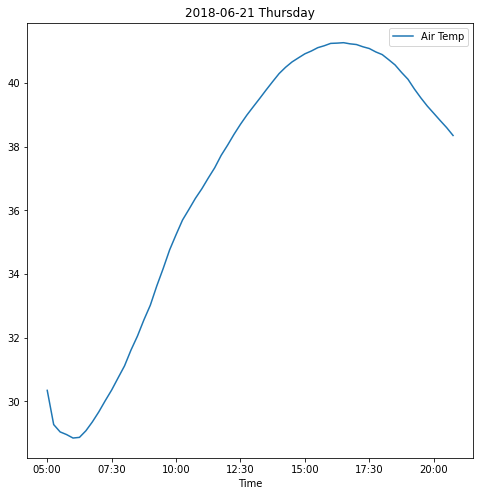

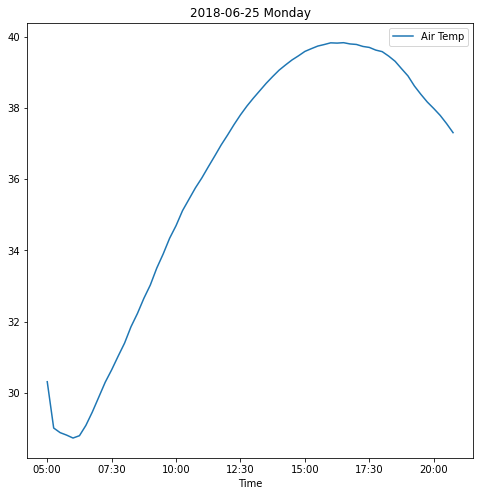

In [29]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg[bldgnum]['Month_num'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg[bldgnum][(Bldg[bldgnum]['Month_num'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

### 2.2.3 Correlation Matrix

<AxesSubplot:>

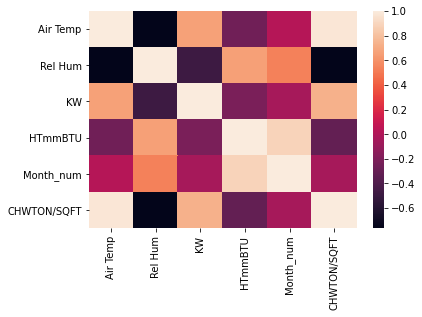

In [30]:
corr_pd = pd.DataFrame(Bldg[bldgnum][['Time','Air Temp','Rel Hum','KW','HTmmBTU','Month_num', 'CHWTON/SQFT']])
corrMatrix = corr_pd.corr()
sns.heatmap(corrMatrix)

## 2.3 Random Forest without tuning

In [31]:
# drop na values if in dataframe
if (Bldg[bldgnum].isnull().values.any() == True):
    Bldg[bldgnum] = Bldg[bldgnum].dropna()
    
# split data into X and y
X = Bldg[bldgnum].drop(columns=['CHWTON/SQFT','Month_num', 'Date', 'Time','bldgname','HTmmBTU', 'Date_Time', 'CHWTON', 'KW', 'Minute_num'])
y = Bldg[bldgnum]['CHWTON/SQFT']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Set up model. Number of trees 100
base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train data
base_RF.fit(X_train, y_train)

# Get prediction
y_pred = base_RF.predict(X_test)
ModelPred = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

score = base_RF.score(X_test, y_test)
rf_score = pd.DataFrame({"bldgname": Bldg[bldgnum]['bldgname'].unique()[0], "test score (on 20% of data)": [score]})
rf_score

       Actual  Predicted
2    0.001195   0.001224
9    0.001356   0.001294
10   0.001438   0.001463
13   0.001586   0.001511
14   0.001658   0.001606
..        ...        ...
573  0.002317   0.002334
582  0.002404   0.002378
583  0.002371   0.002363
587  0.002351   0.002316
592  0.002264   0.002173

[103 rows x 2 columns]


,bldgname,test score (on 20% of data)
0,Goldwater,0.977297


# 3. All Buildings

## 3.1 EDA

### 3.1.1 Boxplots

In [32]:
## Print all boxplots for all buildings ##
for i in range(len(Bldg)):
    Bldg[i].boxplot(by='Hour_num', column=x[colname], grid = False, figsize = (8,8))

IndexError: index 12 is out of bounds for axis 0 with size 5

### 3.1.2 Time Series

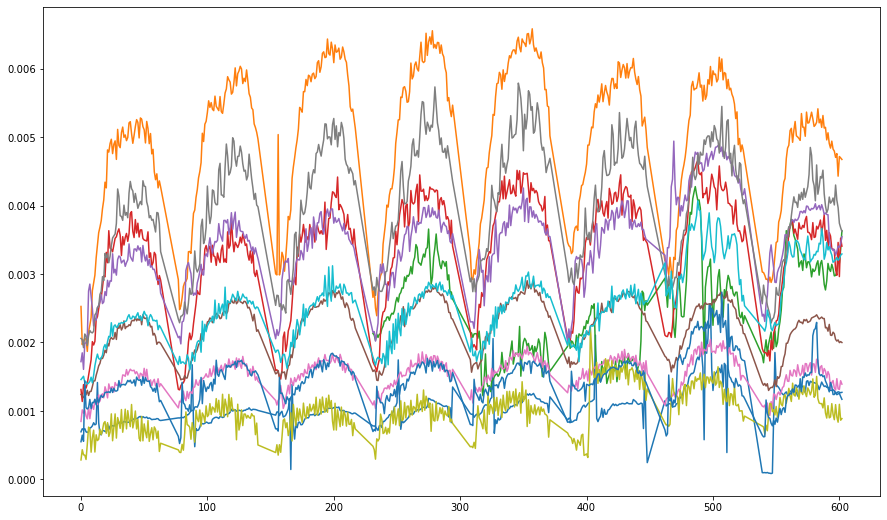

In [34]:
## Print CHWTON/SQFT for all buildings and all timestamps in data
ax = Bldg[0]['CHWTON/SQFT'].plot(figsize = (15,9))
for i in range(len(Bldg)-1):
    Bldg[i+1]['CHWTON/SQFT'].plot(ax=ax)

In [400]:
plotdf1

,bldgname,Date,Time,Air Temp,Rel Hum,KW,CHWTON,HTmmBTU,Date_Time,Month_num,Hour_num,Minute_num,CHWTON/SQFT
385,Psychology,2018-06-25,05:00,29.285559,21.653102,114.00,140.77,0.19,2018-06-25 05:00:00,6,5,0,0.002015
386,Psychology,2018-06-25,05:15,28.871978,24.832182,112.08,153.53,0.18,2018-06-25 05:15:00,6,5,15,0.002198
387,Psychology,2018-06-25,05:30,28.738585,25.218217,112.50,144.40,0.19,2018-06-25 05:30:00,6,5,30,0.002067
388,Psychology,2018-06-25,05:45,28.662380,25.705355,119.71,155.42,0.16,2018-06-25 05:45:00,6,5,45,0.002225
389,Psychology,2018-06-25,06:00,28.571354,26.497466,131.02,163.34,0.13,2018-06-25 06:00:00,6,6,0,0.002338
...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,Psychology,2018-06-25,19:45,38.045354,10.866281,138.09,254.92,0.23,2018-06-25 19:45:00,6,19,45,0.003649
445,Psychology,2018-06-25,20:00,37.893974,10.947621,136.50,255.09,0.23,2018-06-25 20:00:00,6,20,0,0.003651
446,Psychology,2018-06-25,20:15,37.721590,11.122747,138.15,249.40,0.24,2018-06-25 20:15:00,6,20,15,0.003570
447,Psychology,2018-06-25,20:30,37.537615,11.281938,135.01,245.15,0.24,2018-06-25 20:30:00,6,20,30,0.003509


## Random Forest without tuning


In [39]:
### Create dataframe and add building names ###
rf_bld_scores = pd.DataFrame(columns = {"bldgname", "test score (on 20% of data)"})
for i in range(len(Bldg)):
    rf_bld_scores = rf_bld_scores.append({'bldgname': Bldg[i]['bldgname'].unique()[0]}, ignore_index=True)
rf_bld_scores.fillna(5)

### Append scores to all buildings ###

for i in range(len(Bldg)):
    
    # drop na values if in dataframe
    if (Bldg[i].isnull().values.any() == True):
        Bldg[i] = Bldg[i].dropna()
        
    # split data into X and y
    X = Bldg[i].drop(columns=['Month_num', 'Date', 'Time','bldgname','HTmmBTU', 'Date_Time', 'CHWTON', 'KW', 'Minute_num'])
    y = Bldg[i]['CHWTON']
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    
    # Set up model. Number of trees 100
    base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

    # Train data
    base_RF.fit(X_train, y_train)

    # Get prediction
    y_pred = base_RF.predict(X_test)
    ModelPred = pd.DataFrame({'Actual CHWTON':y_test, 'Predicted CHWTON':y_pred})
    ModelPred = ModelPred.sort_index()
    
    # Save scores
    score = base_RF.score(X_test, y_test)
    rf_bld_scores['test score (on 20% of data)'][i] = score
    
rf_bld_scores

,test score (on 20% of data),bldgname
0,0.998082,Noble Library
1,0.999854,Biodesign B
2,0.999179,Biodesign C
3,0.999945,Biodesign A
4,0.998314,Psychology
5,0.999873,Goldwater
6,0.999881,Schwada COB
7,0.999765,ISTB 2
8,0.999361,Bulldog Hall
9,0.99971,ISTB 4
